NESTML active dendrite third-factor STDP synapse
==========================================

In this tutorial, the neuron with dendritic action potentials from the [NESTML active dendrite tutorial](https://nestml.readthedocs.io/en/latest/tutorials/active_dendrite/nestml_active_dendrite_tutorial.html) is combined with a spike-timing dependent synaptic plasticity model. The dendritic action potential current acts as the "third factor" in the learning rule (in addition to pre- and postsynaptic spike timings) and is used to gate the weight update: changes in the weight can only occur during the postsynaptic neuron's dendritic action potential.

<a name="introduction"></a>

Introduction
------------


In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import random
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
from pynestml.codegeneration.nest_tools import NESTTools


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Mar 26 2024 08:52:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



/home/charl/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Reference model

First we define some helper functions that we can use to simulate the desired behaviour of the learning rule. We can then test that the NESTML model behaves in exactly the same way to validate the method.

In [2]:
def get_trace_at(t, t_spikes, tau, initial=0., increment=1., before_increment=True, extra_debug=False):
    if extra_debug:
        print("\t-- obtaining trace at t = " + str(t))
    if len(t_spikes) == 0:
        return initial
    tr = initial
    t_sp_prev = 0.
    for t_sp in t_spikes:
        if t_sp > t:
            break
        if extra_debug:
            _tr_prev = tr
        tr *= np.exp(-(t_sp - t_sp_prev) / tau)
        if t_sp == t:  # exact floating point match!
            if before_increment:
                if extra_debug:
                    print("\t   [%] exact (before_increment = T), prev trace = " + str(_tr_prev) + " at t = " + str(t_sp_prev)
                          + ", decayed by dt = " + str(t - t_sp_prev) + ", tau = " + str(tau) + " to t = " + str(t) + ": returning trace: " + str(tr))
                return tr
            else:
                if extra_debug:
                    print("\t   [%] exact (before_increment = F), prev trace = " + str(_tr_prev) + " at t = " + str(t_sp_prev) + ", decayed by dt = " + str(
                        t - t_sp_prev) + ", tau = " + str(tau) + " to t = " + str(t) + ": returning trace: " + str(tr + increment))
                return tr + increment
        tr += increment
        t_sp_prev = t_sp
    if extra_debug:
        _tr_prev = tr
    tr *= np.exp(-(t - t_sp_prev) / tau)
    if extra_debug:
        print("\t   [&] prev trace = " + str(_tr_prev) + " at t = " + str(t_sp_prev) + ", decayed by dt = "
              + str(t - t_sp_prev) + ", tau = " + str(tau) + " to t = " + str(t) + ": returning trace: " + str(tr))
    return tr


In [51]:
def run_reference_simulation(pre_spike_times,
                             post_spike_times,
                             stepwise_times, stepwise_values, delay):
    lmbda = 1E-6
    tau_tr_pre = 10.
    tau_tr_post = 10.
    alpha = 1.
    mu_plus = 0.
    mu_minus = 0.
    Wmax = 100.
    Wmin = 0.
    third_factor_max = 100.

    post_spike_times = list(np.array(post_spike_times) + delay)  # + delay to make the post spike times
                                                                 # from the synapse perspective
    
    stepwise_state = 0
    third_factor = stepwise_values[0] / third_factor_max
    w = 1.
    t_log = [0.]
    w_log = [w]
    third_factor_log = [third_factor]

    for t in sorted(pre_spike_times + post_spike_times):
        pre_trace = get_trace_at(t, pre_spike_times, tau_tr_pre, extra_debug=False)
        post_trace = get_trace_at(t, post_spike_times, tau_tr_post, extra_debug=False)

        while stepwise_state < len(stepwise_times) - 1 and t >= stepwise_times[stepwise_state + 1]:
            stepwise_state += 1

        if stepwise_values[stepwise_state] is not None:
            third_factor = stepwise_values[stepwise_state] / third_factor_max
        print("~~~~~~~ at t = " + str(t) + " , 3rd factor = " + str(third_factor))
        if t in post_spike_times:
            # potentiate synapse
            print("At t = " + str(t) + ", post spike")
            w_ = Wmax * ( w / Wmax  + (lmbda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
            w_ = third_factor * w_ + (1 - third_factor) * w   # "gating" of the weight update
            w = min(Wmax, w_)
            print("\t---> pre_tr = " + str(pre_trace) + ", new weight = " + str(w))

        if t in pre_spike_times:
            print("At t = " + str(t) + ", pre spike")
            # depress synapse
            w_ = Wmax * ( w / Wmax  - ( alpha * lmbda * ( w / Wmax )**mu_minus * post_trace ))
            w_ = third_factor * w_ + (1 - third_factor) * w   # "gating" of the weight update
            w = max(Wmin, w_)
            print("\t---> post_tr = " + str(post_trace) + ", new weight = " + str(w))

        t_log.append(t)
        w_log.append(w)
        third_factor_log.append(third_factor)
        
    return t_log, w_log, third_factor_log

In [52]:
def plot_reference_simulation(t_log, w_log, third_factor_log, delay, pre_spike_times, post_spike_times):
    
    sim_time = np.amax(t_log)
    
    fig, ax = plt.subplots(nrows=6, figsize=(8, 8))

    n_spikes = len(pre_spike_times)
    for i in range(n_spikes):
        ax[0].plot(2 * [pre_spike_times[i]], [0, 1], linewidth=2, color="blue", alpha=.4)

    ax[0].set_ylabel("Pre spikes")

    n_spikes = len(post_spike_times)
    for i in range(n_spikes):
        ax[-4].plot(2 * [post_spike_times[i] + delay], [0, 1], linewidth=2, color="black", alpha=.4)
    ax[-4].set_ylabel("Post spikes")

    ax[-3].plot(t_log, third_factor_log)
    ax[-3].set_ylim(0, 1.1 * np.amax(third_factor_log))
    ax[-3].set_ylabel("3rd factor")

    ax[-2].semilogy(t_log[:-1], np.abs(np.diff(w_log)), marker="o", label=u"Δw")
    ax[-2].set_ylabel(u"|Δw|")

    ax[-1].plot(t_log, w_log, marker="o")
    ax[-1].set_ylabel("w")
    ax[-1].set_xlabel("Time [ms]")
    for _ax in ax:
        if not _ax == ax[-1]:
            _ax.set_xticklabels([])
        _ax.grid(True)
        _ax.set_xlim(0., sim_time)

    fig.savefig("/tmp/stdp_third_factor_synapse_test_ref.png", dpi=300)

A simple example:

Automatic pdb calling has been turned ON
~~~~~~~ at t = 15.0 , 3rd factor = 1.0
At t = 15.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 20.0 , 3rd factor = 1.0
At t = 20.0, post spike
	---> pre_tr = 0.6065306597126334, new weight = 1.0000606530659713
~~~~~~~ at t = 55.0 , 3rd factor = 1.0
At t = 55.0, pre spike
	---> post_tr = 0.0301973834223185, new weight = 1.000057633327629
~~~~~~~ at t = 60.0 , 3rd factor = 1.0
At t = 60.0, post spike
	---> pre_tr = 0.6176396562508758, new weight = 1.000119397293254
~~~~~~~ at t = 90.0 , 3rd factor = 1.0
At t = 90.0, pre spike
	---> post_tr = 0.050698950333418466, new weight = 1.0001143273982207
~~~~~~~ at t = 105.0 , 3rd factor = 1.0
At t = 105.0, post spike
	---> pre_tr = 0.22999151695160197, new weight = 1.0001373265499158
~~~~~~~ at t = 130.0 , 3rd factor = 1.0
At t = 130.0, pre spike
	---> post_tr = 0.08301358229024355, new weight = 1.0001290251916868
~~~~~~~ at t = 145.0 , 3rd factor = 1.0
At t = 145.0, post spike
	---> pr

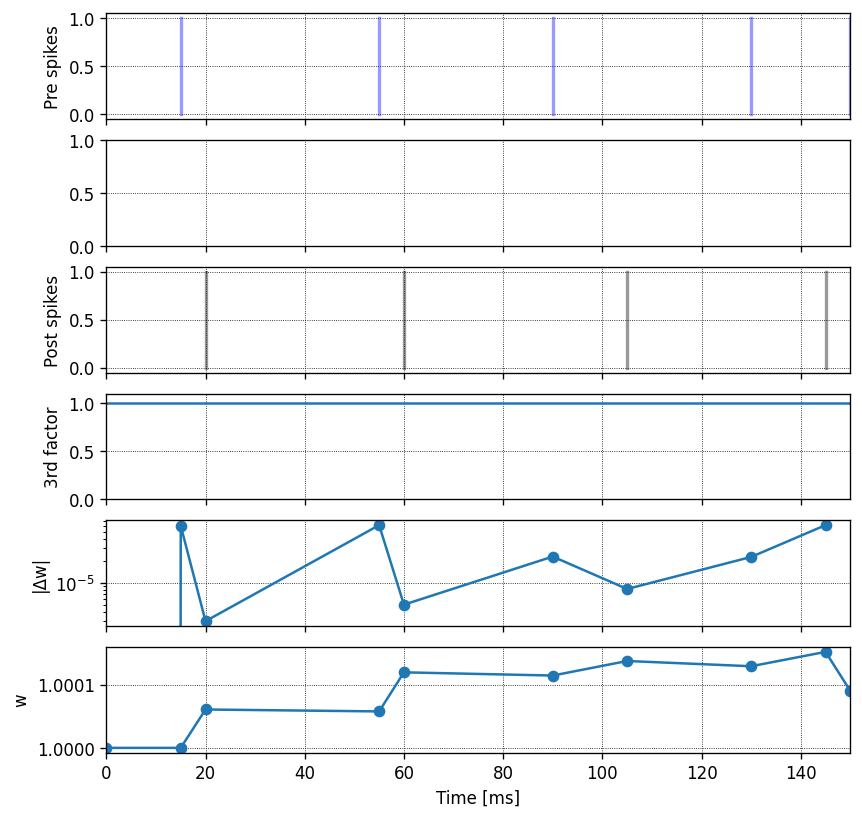

In [53]:
%pdb
pre_spike_times = [15., 55., 90., 130., 150.]      # [ms]
post_spike_times = [10., 50., 95., 135.]      # [ms]
delay = 10.    # [ms]
t_log, w_log, third_factor_log = run_reference_simulation(pre_spike_times=pre_spike_times,
                                                          post_spike_times=post_spike_times,
                                                          stepwise_times=[0.],
                                                          stepwise_values=[100.],
                                                          delay=delay)
plot_reference_simulation(t_log, w_log, third_factor_log, delay, pre_spike_times, post_spike_times)

## Generating code with NESTML

We use the same neuron model as in the tutorial:
added I_syn = 0 reset on AP


In [54]:
nestml_neuron_model = '''
model iaf_psc_exp_active_dendrite_neuron:
    state:
        V_m mV = 0 mV     # membrane potential
        t_dAP ms = 0 ms   # dendritic action potential timer
        I_dAP pA = 0 pA   # dendritic action potential current magnitude

    equations:
        # alpha shaped postsynaptic current kernel
        kernel syn_kernel = (e / tau_syn) * t * exp(-t / tau_syn)
        kernel sg_kernel = delta(t)
        recordable inline I_syn pA = convolve(syn_kernel, synaptic_spikes) * pA
        V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dAP + I_e) / C_m + convolve(sg_kernel, spike_generator_spikes) * mV / s
        I_dAP' = -I_dAP / tau_dAP

    parameters:
        C_m pF = 250 pF          # capacity of the membrane
        tau_m ms = 20 ms         # membrane time constant
        tau_syn ms = 10 ms       # time constant of synaptic current
        V_th mV = 25 mV          # action potential threshold
        V_reset mV = 0 mV        # reset voltage
        I_e    pA = 0 pA         # external current
        E_L    mV = 0 mV         # resting potential

        # dendritic action potential
        I_th pA = 100 pA         # current threshold for a dendritic action potential
        I_dAP_peak pA = 100 pA   # current clamp value for I_dAP during a dendritic action potential
        T_dAP ms = 10 ms         # time window over which the dendritic current clamp is active
        tau_dAP ms = 100 ms         # if ``reset_I_dAP_after_AP`` is false, I_dAP decays back to zero with this time constant
        reset_I_dAP_after_AP boolean = true

    input:
        synaptic_spikes <- spike
        spike_generator_spikes <- spike

    output: 
        spike

    update:
        # solve ODEs
        if reset_I_dAP_after_AP:
            integrate_odes(V_m)
        else:
            integrate_odes(V_m, I_dAP)

        if t_dAP > 0 ms:
            t_dAP -= resolution()
            if t_dAP <= 0 ms:
                # end of dendritic action potential
                t_dAP = 0 ms
                if reset_I_dAP_after_AP:
                    I_dAP = 0 pA

    onCondition(I_syn > I_th):
        # current-threshold, emit a dendritic action potential
        t_dAP = T_dAP
        I_dAP = I_dAP_peak

    onCondition(V_m > V_th):
        # emit somatic action potential
        emit_spike()
        V_m = V_reset
        I_syn = 0 pA
'''

For the synapse model, ...

In [7]:
nestml_synapse_model = '''
"""
third_factor_stdp_synapse - Synapse model for spike-timing dependent plasticity with postsynaptic third-factor modulation
#########################################################################################################################

Description
+++++++++++

third_factor_stdp_synapse is a synapse with spike time dependent plasticity (as defined in [1]). Here the weight dependence exponent can be set separately for potentiation and depression. Examples::

For references and more details, please see the original stdp_synapse model.
"""
model third_factor_stdp_synapse:
    state:
        w real = 1.    # Synaptic weight

    parameters:
        d ms = 1 ms    # Postsynaptic dendritic delay
        lambda real = .01
        tau_tr_pre ms = 10 ms
        tau_tr_post ms = 10 ms
        alpha real = 1.
        mu_plus real = 1.
        mu_minus real = 1.
        Wmax real = 100.
        Wmin real = 0.
        I_post_dend_peak pA = 100 pA   # current clamp value for I_dAP during a dendritic action potential

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

        # all-to-all trace of postsynaptic neuron
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

    input:
        pre_spikes <- spike
        post_spikes <- spike
        I_post_dend pA <- continuous

    output:
        spike

    onReceive(post_spikes):
        # potentiate synapse
        w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
        if I_post_dend <= I_post_dend_peak:
            w_ = (I_post_dend / I_post_dend_peak) * w_ + (1 - I_post_dend / I_post_dend_peak) * w   # "gating" of the weight update
        w = min(Wmax, w_)

    onReceive(pre_spikes):
        # depress synapse
        w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
        if I_post_dend <= I_post_dend_peak:
            w_ = (I_post_dend / I_post_dend_peak) * w_ + (1 - I_post_dend / I_post_dend_peak) * w   # "gating" of the weight update
        w = max(Wmin, w_)

        # deliver spike to postsynaptic partner
        emit_spike(w, d)

    update:
        integrate_odes()

'''

We will use a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "iaf_psc_alpha_3cc945f". The resulting neuron model name is returned by the function, so we do not have to think about these internals.

In [8]:
# generate and build code
from pynestml.frontend.pynestml_frontend import generate_nest_target

with open("iaf_psc_exp_active_dendrite_neuron.nestml", "w") as f:
    f.write(nestml_neuron_model)
with open("third_factor_stdp_synapse.nestml", "w") as f:
    f.write(nestml_synapse_model)

        
codegen_opts = {"neuron_synapse_pairs": [{"neuron": "iaf_psc_exp_active_dendrite_neuron",
                                          "synapse": "third_factor_stdp_synapse",
                                          "post_ports": ["post_spikes",
                                                         ["I_post_dend", "I_dAP"]]}],
                "delay_variable": {"third_factor_stdp_synapse": "d"},
                "weight_variable": {"third_factor_stdp_synapse": "w"}}
input_path = ["iaf_psc_exp_active_dendrite_neuron.nestml",
              "third_factor_stdp_synapse.nestml"]
generate_nest_target(input_path=input_path,
                     logging_level="DEBUG",
                     codegen_opts=codegen_opts)

neuron_model_name = "iaf_psc_exp_active_dendrite_neuron__with_third_factor_stdp_synapse"
synapse_model_name = "third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron"

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/iaf_psc_exp_active_dendrite_neuron.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/third_factor_stdp_synapse.nestml
[4,GLOBAL, INFO]: Target platform code will be generated in directory: '/home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target'
[5,GLOBAL, INFO]: No module name specified; the generated module will be named "nestmlmodule"

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0-post0.dev0
 Built: Mar 26 2024 08:52:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[6,GLO

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_m' = (-(V_m - E_L)) / tau_m + ((syn_kernel__X__synaptic_spikes * 1.0) + I_dAP + I_e) / C_m + 0 * 1.0 / 1000.0",
            "initial_values": {
                "V_m": "0"
            }
        },
        {
            "expression": "I_dAP' = (-I_dAP) / tau_dAP",
            "initial_values": {
                "I_dAP": "0"
            }
        },
        {
            "expression": "syn_kernel__X__synaptic_spikes = (e / tau_syn) * t * exp(-t / tau_syn)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "0",
        "I_dAP_peak": "100",
        "I_e": "0",
        "I_th": "100",
        "T_dAP": "10",
        "V_reset": "0",
        "V_th": "25",
        "reset_I_dAP_after_AP": "true",
        "tau_dAP": "100",
        "tau_m": "20",
        "tau_syn": "10"
    }
}
INFO:Processing g

DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable_before_propagated.dot']
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating propagators for the following symbols: V_m, I_dAP, syn_kernel__X__synaptic_spikes, syn_kernel__X__synaptic_spikes__d
DEBUG:Initializing system of shapes with x = Matrix([[V_m], [I_dAP], [syn_kernel__X__synaptic_spikes], [syn_kernel__X__synaptic_spikes__d]]), A = Matrix([[-1/tau_m, 1/C_m, 1.0/C_m, 0], [0, -1/tau_dAP, 0, 0], [0, 0, 0, 1.00000000000000], [0, 0, -1/tau_syn**2, -2/tau_syn]]), b = Matrix([[E_L/tau_m + I_e/C_m], [0], [0], [0]]), c = Matr

[58,iaf_psc_exp_active_dendrite_neuron, DEBUG, [2:0;63:0]]: Start building symbol table!
[59,iaf_psc_exp_active_dendrite_neuron, INFO, [63:16;63:18]]: Implicit casting from (compatible) type 'pA' to 'real'.
[60,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_active_dendrite_neuron__with_third_factor_stdp_synapse'
[61,iaf_psc_exp_active_dendrite_neuron__with_third_factor_stdp_synapse, INFO, [2:0;63:0]]: Starts processing of the model 'iaf_psc_exp_active_dendrite_neuron__with_third_factor_stdp_synapse'


INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_m' = (-(V_m - E_L)) / tau_m + ((syn_kernel__X__synaptic_spikes * 1.0) + I_dAP + I_e) / C_m + 0 * 1.0 / 1000.0",
            "initial_values": {
                "V_m": "0"
            }
        },
        {
            "expression": "I_dAP' = (-I_dAP) / tau_dAP",
            "initial_values": {
                "I_dAP": "0"
            }
        },
        {
            "expression": "syn_kernel__X__synaptic_spikes = (e / tau_syn) * t * exp(-t / tau_syn)",
            "initial_values": {}
        },
        {
            "expression": "post_trace_kernel__for_third_factor_stdp_synapse__X__post_spikes__for_third_factor_stdp_synapse = exp(-t / tau_tr_post__for_third_factor_stdp_synapse)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "0",
        "I_dAP_peak": "100",
        "I_e": "

DEBUG:	linear factors: Matrix([[0], [0], [-1/tau_syn**2], [-2/tau_syn], [0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
INFO:Shape post_trace_kernel__for_third_factor_stdp_synapse__X__post_spikes__for_third_factor_stdp_synapse: reconstituting expression -post_trace_kernel__for_third_factor_stdp_synapse__X__post_spikes__for_third_factor_stdp_synapse/tau_tr_post__for_third_factor_stdp_synapse
DEBUG:Splitting expression -post_trace_kernel__for_third_factor_stdp_synapse__X__post_spikes__for_third_factor_stdp_synapse/tau_tr_post__for_third_factor_stdp_synapse (symbols Matrix([[V_m], [I_dAP], [syn_kernel__X__synaptic_spikes], [syn_kernel__X__synaptic_spikes__d], [post_trace_kernel__for_third_factor_stdp_synapse__X__post_spikes__for_third_factor_stdp_synapse]]))
DEBUG:	linear factors: Matrix([[0], [0], [0], [0], [-1/tau_tr_post__for_third_factor_stdp_synapse]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Initializing system of shapes with x = Matrix([[V_m],

[62,iaf_psc_exp_active_dendrite_neuron__with_third_factor_stdp_synapse, DEBUG, [2:0;63:0]]: Start building symbol table!


INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_trace_kernel__X__pre_spikes = exp(-t / tau_tr_pre)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "I_post_dend_peak": "100",
        "Wmax": "100.0",
        "Wmin": "0.0",
        "alpha": "1.0",
        "d": "1",
        "lambda": "0.01",
        "mu_minus": "1.0",
        "mu_plus": "1.0",
        "tau_tr_post": "10",
        "tau_tr_pre": "10"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing function-of-time shape "pre_trace_kernel__X__pre_spikes" with defining expression = "exp(-t/tau_tr_pre)"
DEBUG:Found t: 0
DEBUG:	Finding ode for order 1...
DEBUG:Shape satisfies ODE of order = 1
DEBUG:Created Shape with symbol pre_trace_kernel__X__pre_spikes, derivative_factors = [-1/tau_tr_pre], inhom_term = 0.0, nonlin_term = 0.0
INFO:Shape pre_trace_kernel__X__pre_spik

[63,iaf_psc_exp_active_dendrite_neuron__with_third_factor_stdp_synapse, INFO, [63:16;63:18]]: Implicit casting from (compatible) type 'pA' to 'real'.
[64,GLOBAL, INFO]: Analysing/transforming synapse third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron.
[65,third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron, INFO, [13:0;63:0]]: Starts processing of the model 'third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron'


INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating propagators for the following symbols: pre_trace_kernel__X__pre_spikes
DEBUG:Initializing system of shapes with x = Matrix([[pre_trace_kernel__X__pre_spikes]]), A = Matrix([[-1/tau_tr_pre]]), b = Matrix([[0]]), c = Matrix([[0]])
DEBUG:System of equations:
DEBUG:x = Matrix([[pre_trace_kernel__X__pre_spikes]])
DEBUG:A = Matrix([[-1/tau_tr_pre]])
DEBUG:b = Matrix([[0]])
DEBUG:c = Matrix([[0]])
INFO:update_expr[pre_trace_kernel__X__pre_spikes] = __P__pre_trace_kernel__X__pre_spikes__pre_trace_kernel__X__pre_spikes*pre_trace_kernel__X__pre_spikes
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "pre_trace_kernel__X__pre_spikes": "1"
        }

[66,third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron, DEBUG, [13:0;63:0]]: Start building symbol table!
[67,third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron, WARNING, [18:8;18:17]]: Variable 'd' has the same name as a physical unit!
[68,third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron, DEBUG, [13:0;63:0]]: Start building symbol table!
[69,third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron, WARNING, [18:8;18:17]]: Variable 'd' has the same name as a physical unit!
[70,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/iaf_psc_exp_active_dendrite_neuron.cpp
[71,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/iaf_psc_exp_active_dendrite_neuron.h
[72,iaf_psc_exp_active_dendrite_neuron, INFO, [2:0;63:0]]: Successfully generated code f

In file included from /home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/nestmlmodule.cpp:36:
/home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron.h: In instantiation of ‘nest::third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron<targetidentifierT>::third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron() [with targetidentifierT = nest::TargetIdentifierPtrRport]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_model.h:164:25:   required from ‘nest::GenericConnectorModel<ConnectionT>::GenericConnectorModel(std::string) [with ConnectionT = nest::third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron<nest::TargetIdentifierPtrRport>; std::string = std::__cxx11::basic_string<char>]’
/home/charl/julich/nest-simulator-install/include/nest/model_manager_imp

/home/charl/julich/nestml-fork-third_factor_stdp/nestml/doc/tutorials/stdp_third_factor_active_dendrite/target/third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron.h: In instantiation of ‘bool nest::third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron<targetidentifierT>::send(nest::Event&, size_t, const nest::third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuronCommonSynapseProperties&) [with targetidentifierT = nest::TargetIdentifierPtrRport; size_t = long unsigned int]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:391:22:   required from ‘void nest::Connector<ConnectionT>::send_to_all(size_t, const std::vector<nest::ConnectorModel*>&, nest::Event&) [with ConnectionT = nest::third_factor_stdp_synapse__with_iaf_psc_exp_active_dendrite_neuron<nest::TargetIdentifierPtrRport>; size_t = long unsigned int]’
/home/charl/julich/nest-simulator-install/include/nest/connector_base.h:383:3:   required from here
/home/charl/julic

[100%] Linking CXX shared module nestmlmodule.so
[100%] Built target nestmlmodule_module
[100%] Built target nestmlmodule_module
Install the project...
-- Install configuration: ""
-- Installing: /home/charl/julich/nest-simulator-install/lib/nest/nestmlmodule.so


Now, the NESTML model is ready to be used in a simulation by calling ``nest.Install("nestmlmodule")``.

Numerical validation
--------------------

We will run some validation experiments for a small, predefined set of pre- and postsynaptic spike times.

In [55]:
def run_synapse_test(neuron_model_name,
                     synapse_model_name,
                     resolution=1.,  # [ms]
                     delay=1.,  # [ms]
                     sim_time=None,  # if None, computed from pre and post spike times
                     pre_spike_times=None,
                     post_spike_times=None,
                     fname_snip="",
                     stepwise_times=None,
                     stepwise_values=None,
                     reset_I_dAP_after_AP=True,
                     verbose=False):

    if pre_spike_times is None:
        pre_spike_times = []

    if post_spike_times is None:
        post_spike_times = []

    if sim_time is None:
        sim_time = max(np.amax(pre_spike_times), np.amax(post_spike_times)) + 1.1 * delay

    nest.ResetKernel()
    #nest.set_verbosity("M_WARNING")
    nest.set_verbosity("M_ALL")
    nest.Install("nestmlmodule")

    print("Pre spike times: " + str(pre_spike_times))
    print("Post spike times: " + str(post_spike_times))

    nest.SetKernelStatus({"resolution": resolution})

    wr = nest.Create("weight_recorder")
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                    {"weight_recorder": wr[0], "w": 1., "d": delay, "receptor_type": 0, "lambda": 1E-6,
                    "mu_plus": 0.,   # for additive STDP
                    "mu_minus": 0.})   # for additive STDP

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                            params={"spike_times": pre_spike_times})
    post_sg = nest.Create("spike_generator",
                            params={"spike_times": post_spike_times,
                                    "allow_offgrid_times": True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)
    post_neuron.I_th = 1500.
    post_neuron.I_dAP_peak = 10.
    post_neuron.reset_I_dAP_after_AP = reset_I_dAP_after_AP
    receptor_types = nest.GetStatus(post_neuron, "receptor_types")[0]

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    mm = nest.Create("multimeter", params={"record_from": ["V_m", "I_dAP"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1.,
                                                               "weight": 100000.,
                                                               "receptor_type" : receptor_types["SPIKE_GENERATOR_SPIKES"]})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={"synapse_model": "stdp_nestml_rec",
                                                                  "receptor_type" : receptor_types["SYNAPTIC_SPIKES"]})
    nest.Connect(mm, post_neuron)
    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")

    t = 0.
    t_hist = []
    w_hist = []
    state = 0
    while t <= sim_time:
        if verbose:
            print("t = " + str(t) + " ms")
        if stepwise_times is not None and stepwise_values is not None:
            assert len(stepwise_times) == len(stepwise_values)
            
            if state < len(stepwise_times) - 1 and t >= stepwise_times[state + 1]:
                state += 1

            if stepwise_values[state] is not None:
                nest.SetStatus(post_neuron, {"I_dAP": stepwise_values[state]})
                nest.SetStatus(post_neuron, {"t_dAP": 1.})

        nest.Simulate(resolution)
        t += resolution
        t_hist.append(t)
        w_hist.append(nest.GetStatus(syn)[0]["w"])

    third_factor_trace = nest.GetStatus(mm, "events")[0]["I_dAP"] / syn[0].I_post_dend_peak
    timevec = nest.GetStatus(mm, "events")[0]["times"]

    # -----------
    
    t_log_ref, w_log_ref, third_factor_log_ref = run_reference_simulation(
                        pre_spike_times=list(np.array(pre_spike_times) + 1.),  # + 1 because of delay from spike gen to neuron
                        post_spike_times=list(np.array(post_spike_times) + 1.),  # + 1 because of delay from spike gen to neuron
                        stepwise_times=stepwise_times,
                        stepwise_values=stepwise_values,
                        delay=delay)

    # -----------

    fig, ax = plt.subplots(nrows=6, figsize=(8, 8))

    pre_spike_times_ = nest.GetStatus(spikedet_pre, "events")[0]["times"]
    print("Actual pre spike times: " + str(pre_spike_times_))

    n_spikes = len(pre_spike_times_)
    for i in range(n_spikes):
        ax[0].plot(2 * [pre_spike_times_[i]], [0, 1], linewidth=2, color="blue", alpha=.4)

    post_spike_times_ = nest.GetStatus(spikedet_post, "events")[0]["times"]
    print("Actual post spike times: " + str(post_spike_times_))
    ax[0].set_ylabel("Pre spikes")

    V_m = nest.GetStatus(mm, "events")[0]["V_m"]
    ax[1].plot(timevec, V_m)
    ax[1].plot([0, timevec[-1]], [post_neuron.V_th, post_neuron.V_th], c="grey", alpha=.7, linestyle="--")
    ax[1].set_ylabel("post V_m")
    
    n_spikes = len(post_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax[-4].plot(2 * [post_spike_times_[i] + delay], [0, 1], linewidth=2, color="black", alpha=.4, label=_lbl)
    ax[-4].set_ylabel("Post spikes")

    ax[-3].plot(timevec, third_factor_trace, alpha=.8, label="NESTML")
    ax[-3].plot(t_log_ref, third_factor_log_ref, alpha=.8, marker="o", label="ref")
    ax[-3].legend()
    ax[-3].set_ylim(0, 1.1 * np.amax(third_factor_trace))
    ax[-3].set_ylabel("3rd factor")

    ax[-2].semilogy(t_hist[:-1], np.abs(np.diff(w_hist)), marker="o", label=u"Δw")
    #ax[-2].set_yscale('symlog')
    ax[-2].set_ylabel(u"|Δw|")

    ax[-1].plot(t_hist, w_hist, alpha=.8, label="nestml")
    ax[-1].plot(t_log_ref, w_log_ref, marker="o", alpha=.8, label="ref")
    
    ax[-1].set_ylabel("w")
    ax[-1].set_xlabel("Time [ms]")
    
    for _ax in ax:
        if not _ax == ax[-1]:
            _ax.set_xticklabels([])
        _ax.grid(True)
        _ax.set_xlim(0., sim_time)

    fig.savefig("/tmp/stdp_third_factor_synapse_test_ref_" + fname_snip + ".png", dpi=300)

    # -----------

    # check that, at the time of each pre spike (because that's when NEST synapse update their state):
    # weight computed with the reference code matches that of the NESTML generated code
    
    for i, t_pre in enumerate(list(np.array(pre_spike_times) + 1.)):  # + 1 because of delay from spike gen to neuron
        ref_idx = np.argmin((t_log_ref - t_pre)**2)
        numeric_result_idx = np.argmin((t_hist - t_pre)**2)
        np.testing.assert_allclose(t_log_ref[ref_idx], t_pre)
        np.testing.assert_allclose(t_hist[numeric_result_idx], t_pre)
        np.testing.assert_allclose(w_log_ref[ref_idx], w_hist[numeric_result_idx + 1])
        

    # -----------

    return timevec, t_hist, third_factor_trace, w_hist


### Case 1: Third factor is zero

In [56]:
pre_spike_times = np.array([15., 65., 115., 165.])      # [ms]
post_spike_times = np.array([10., 60., 110.])    # [ms]

Pre spike times: [ 15.  65. 115. 165.]
Post spike times: [ 10.  60. 110.]
~~~~~~~ at t = 13.0 , 3rd factor = 0.0
At t = 13.0, post spike
	---> pre_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 16.0 , 3rd factor = 0.0
At t = 16.0, pre spike
	---> post_tr = 0.7408182206817179, new weight = 1.0
~~~~~~~ at t = 63.0 , 3rd factor = 0.0
At t = 63.0, post spike
	---> pre_tr = 0.009095277101695816, new weight = 1.0
~~~~~~~ at t = 66.0 , 3rd factor = 0.0
At t = 66.0, pre spike
	---> post_tr = 0.745809814588628, new weight = 1.0
~~~~~~~ at t = 113.0 , 3rd factor = 0.0
At t = 113.0, post spike
	---> pre_tr = 0.009156560596749037, new weight = 1.0
~~~~~~~ at t = 116.0 , 3rd factor = 0.0
At t = 116.0, pre spike
	---> post_tr = 0.7458434476838137, new weight = 1.0
~~~~~~~ at t = 166.0 , 3rd factor = 0.0
At t = 166.0, pre spike
	---> post_tr = 0.005025453620108712, new weight = 1.0
Actual pre spike times: [ 16.  66. 116. 166.]
Actual post spike times: [ 11.  61. 111.]


/tmp/ipykernel_225356/2573028503.py:137: UserWarning:Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
/tmp/ipykernel_225356/2573028503.py:152: UserWarning:Data has no positive values, and therefore cannot be log-scaled.


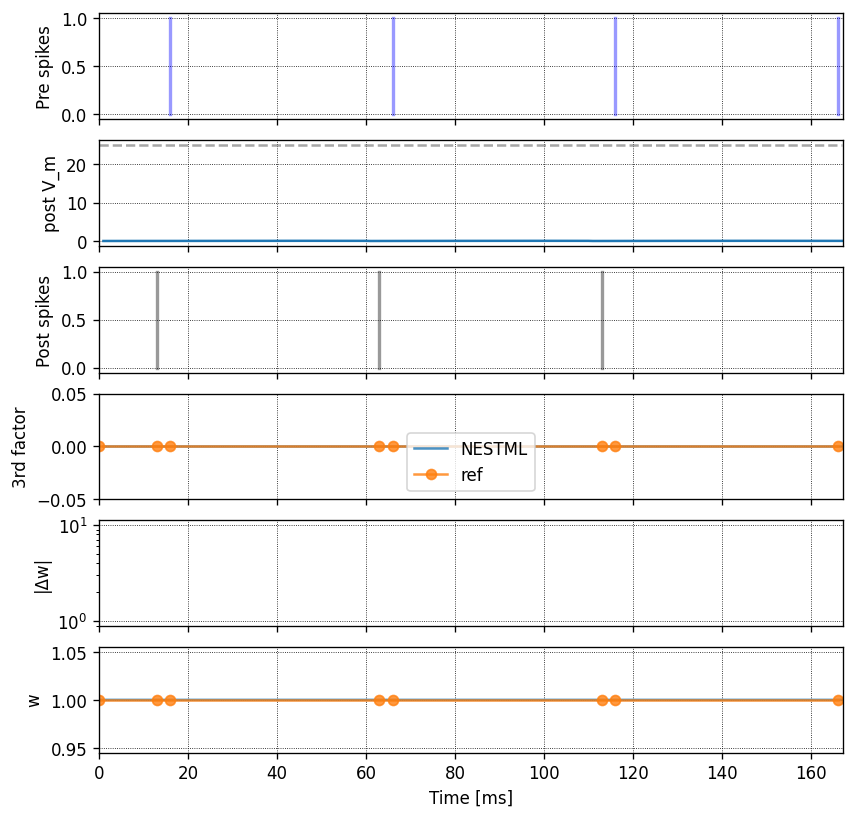

In [57]:
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.1,  # [ms]
                        delay=2.,  # [ms]
                        pre_spike_times=pre_spike_times,
                        post_spike_times=post_spike_times,
                        stepwise_times=[0.], stepwise_values=[0.])

### Case 2: Third factor is always enabled

Pre spike times: [ 15.  65. 115. 165.]
Post spike times: [ 10.  60. 110.]
~~~~~~~ at t = 12.0 , 3rd factor = 1.0
At t = 12.0, post spike
	---> pre_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 16.0 , 3rd factor = 1.0
At t = 16.0, pre spike
	---> post_tr = 0.6703200460356393, new weight = 0.9999329679953964
~~~~~~~ at t = 62.0 , 3rd factor = 1.0
At t = 62.0, post spike
	---> pre_tr = 0.010051835744633586, new weight = 0.9999339731789708
~~~~~~~ at t = 66.0 , 3rd factor = 1.0
At t = 66.0, pre spike
	---> post_tr = 0.674836626978252, new weight = 0.999866489516273
~~~~~~~ at t = 112.0 , 3rd factor = 1.0
At t = 112.0, post spike
	---> pre_tr = 0.010119564481124438, new weight = 0.9998675014727211
~~~~~~~ at t = 116.0 , 3rd factor = 1.0
At t = 116.0, pre spike
	---> post_tr = 0.6748670594612604, new weight = 0.9998000147667749
~~~~~~~ at t = 166.0 , 3rd factor = 1.0
At t = 166.0, pre spike
	---> post_tr = 0.00454721847807863, new weight = 0.9997995600449271
Actual pre spike times: [ 16.  66. 11

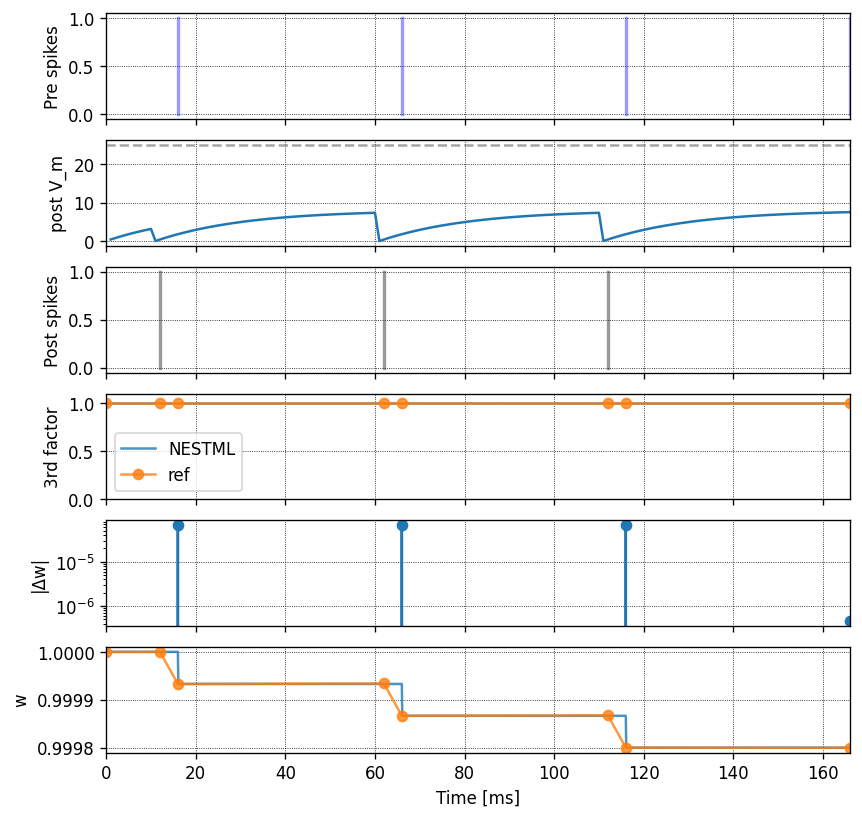

In [58]:
# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.1,  # [ms]
                        delay=1.,  # [ms]
                        pre_spike_times=pre_spike_times,
                        post_spike_times=post_spike_times,
                        stepwise_times=[0.],
                        stepwise_values=[100.])

Pre spike times: [ 10.  60. 110. 160.]
Post spike times: [ 15.  65. 115.]
~~~~~~~ at t = 11.0 , 3rd factor = 1.0
At t = 11.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 17.0 , 3rd factor = 1.0
At t = 17.0, post spike
	---> pre_tr = 0.5488116360940264, new weight = 1.0000548811636094
~~~~~~~ at t = 61.0 , 3rd factor = 1.0
At t = 61.0, pre spike
	---> post_tr = 0.012277339903068436, new weight = 1.0000536534296192
~~~~~~~ at t = 67.0 , 3rd factor = 1.0
At t = 67.0, post spike
	---> pre_tr = 0.5525094998105092, new weight = 1.0001089043796003
~~~~~~~ at t = 111.0 , 3rd factor = 1.0
At t = 111.0, pre spike
	---> post_tr = 0.012360063968625067, new weight = 1.0001076683732033
~~~~~~~ at t = 117.0 , 3rd factor = 1.0
At t = 117.0, post spike
	---> pre_tr = 0.5525344158202408, new weight = 1.0001629218147854
~~~~~~~ at t = 161.0 , 3rd factor = 1.0
At t = 161.0, pre spike
	---> post_tr = 0.012360621358994336, new weight = 1.0001616857526494
Actual pre spike times: [ 11.  61.

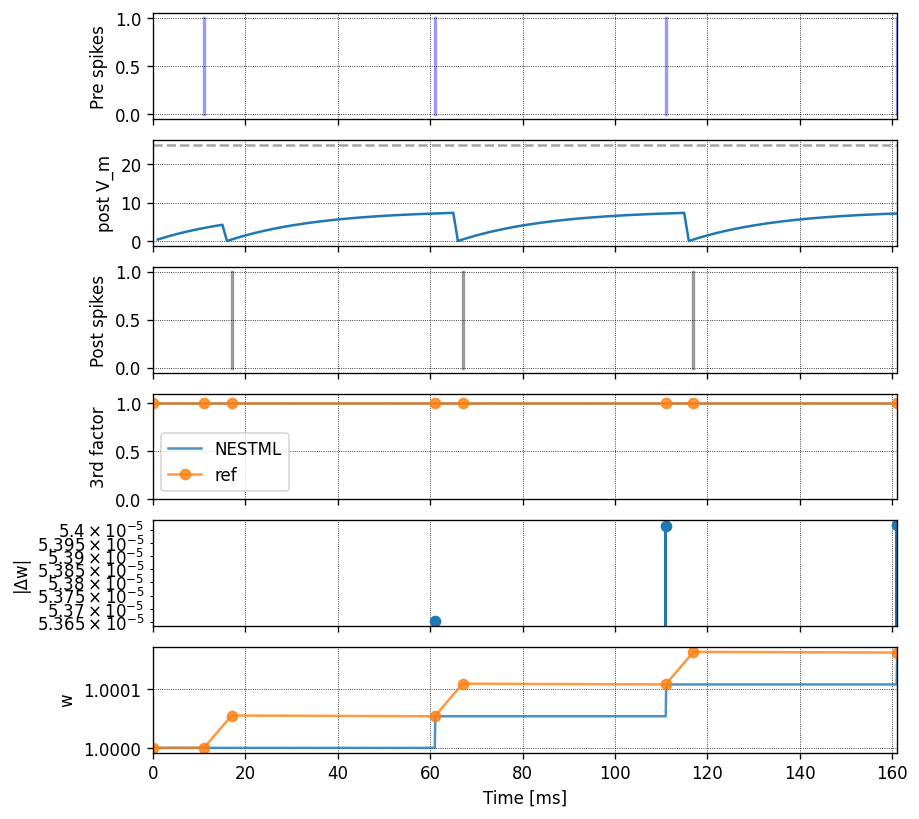

In [59]:
# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.1,  # [ms]
                        delay=1.,  # [ms]
                        pre_spike_times=pre_spike_times - 5.,
                        post_spike_times=post_spike_times + 5,
                        stepwise_times=[0.],
                        stepwise_values=[100.])

### Case 3a: Third factor active during pre but not post spike

In this implementation of the synapse, note that the dendritic action potential current is "gating" the STDP weight updates. This means that all spikes still count, even if the dAP current was zero at that time! The gating only means that whenever a weight update would ordinarily happen in the STDP synapse (when a pre- or postsynaptic spike arrives), the weight update is gated by the dAP *at that time*.

Dendritic delay is 1 ms.

This should result in a strong depression due to the pre spike just after the post spike.

Pre spike times: [ 15.  65. 165.]
Post spike times: [60.]
~~~~~~~ at t = 16.0 , 3rd factor = 0.0
At t = 16.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 62.0 , 3rd factor = 0.0
At t = 62.0, post spike
	---> pre_tr = 0.010051835744633586, new weight = 1.0
~~~~~~~ at t = 66.0 , 3rd factor = 1.0
At t = 66.0, pre spike
	---> post_tr = 0.6703200460356393, new weight = 0.9999329679953964
~~~~~~~ at t = 166.0 , 3rd factor = 0.0
At t = 166.0, pre spike
	---> post_tr = 3.0432483008403625e-05, new weight = 0.9999329679953964
Actual pre spike times: [ 16.  66. 166.]
Actual post spike times: [61.]


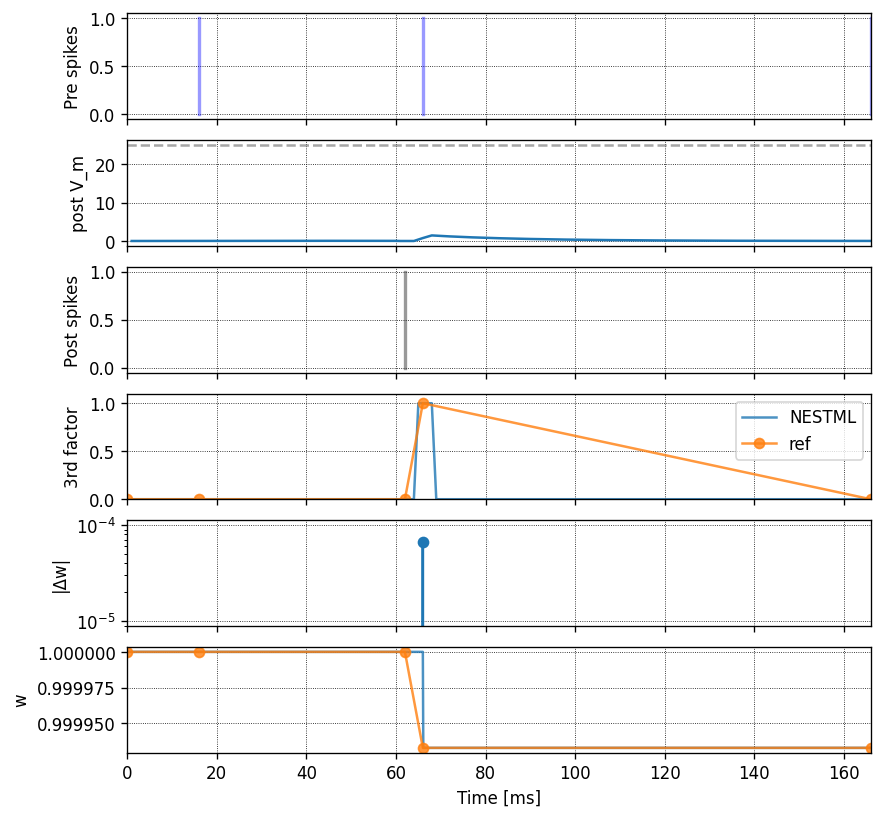

In [74]:
pre_spike_times = np.array([15., 65., 165.])    # [ms]
post_spike_times = np.array([60.])     # [ms]

stepwise_times = [0., 64., 68.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                synapse_model_name=synapse_model_name,
                resolution=.1,  # [ms]
                delay=1.,  # [ms]
                pre_spike_times=pre_spike_times,
                post_spike_times=post_spike_times,
                stepwise_times=stepwise_times, stepwise_values=stepwise_values)

### Case 3b: Third factor active during post but not pre spike

In this implementation of the synapse, note that the dendritic action potential current is "gating" the STDP weight updates. This means that all spikes still count, even if the dAP current was zero at that time! The gating only means that whenever a weight update would ordinarily happen in the STDP synapse (when a pre- or postsynaptic spike arrives), the weight update is gated by the dAP *at that time*.

Dendritic delay is 1 ms.

Pre spike times: [ 15.  65. 165.]
Post spike times: [60.]
~~~~~~~ at t = 16.0 , 3rd factor = 0.0
At t = 16.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 62.0 , 3rd factor = 1.0
At t = 62.0, post spike
	---> pre_tr = 0.010051835744633586, new weight = 1.0000010051835744
~~~~~~~ at t = 66.0 , 3rd factor = 0.0
At t = 66.0, pre spike
	---> post_tr = 0.6703200460356393, new weight = 1.0000010051835744
~~~~~~~ at t = 166.0 , 3rd factor = 0.0
At t = 166.0, pre spike
	---> post_tr = 3.0432483008403625e-05, new weight = 1.0000010051835744
Actual pre spike times: [ 16.  66. 166.]
Actual post spike times: [61.]


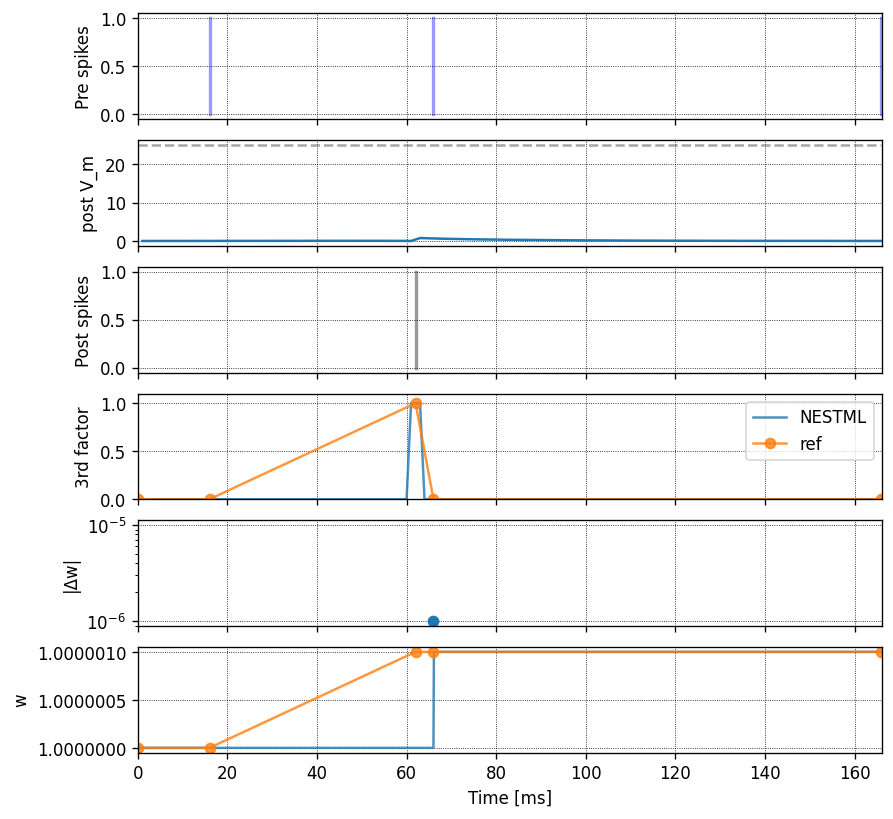

In [75]:
sim_time = 101.

stepwise_times = [0., 60., 63.]
stepwise_values = [0., 100., 0.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                synapse_model_name=synapse_model_name,
                resolution=.1,  # [ms]
                delay=1.,  # [ms]
                pre_spike_times=pre_spike_times,
                post_spike_times=post_spike_times,
                stepwise_times=stepwise_times, stepwise_values=stepwise_values)

### Case 3b: Third factor active during post but not pre spike

Dendritic delay is now 10 ms. With the same third-factor timing, the gating is enabled during the somatic post spike, but not the post spike from the perspective of the synapse, due to the dendritic delay. Because the gate is closed at the time of arrival of the post spike, no change in the weight occurs.

Pre spike times: [ 15.  65. 165.]
Post spike times: [60.]
~~~~~~~ at t = 16.0 , 3rd factor = 0.0
At t = 16.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 66.0 , 3rd factor = 0.0
At t = 66.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
~~~~~~~ at t = 71.0 , 3rd factor = 0.0
At t = 71.0, post spike
	---> pre_tr = 0.6106174311510975, new weight = 1.0
~~~~~~~ at t = 166.0 , 3rd factor = 0.0
At t = 166.0, pre spike
	---> post_tr = 7.48518298877006e-05, new weight = 1.0
Actual pre spike times: [ 16.  66. 166.]
Actual post spike times: [61.]


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 1 / 1 (100%)
Max absolute difference: 6.10617431e-05
Max relative difference: 6.10580148e-05
 x: array(1.)
 y: array(1.000061)

> /home/charl/.local/lib/python3.11/site-packages/numpy/testing/_private/utils.py(844)assert_array_compare()
    842                                 verbose=verbose, header=header,
    843                                 names=('x', 'y'), precision=precision)
--> 844             raise AssertionError(msg)
    845     except ValueError:
    846         import traceback

ipdb> c


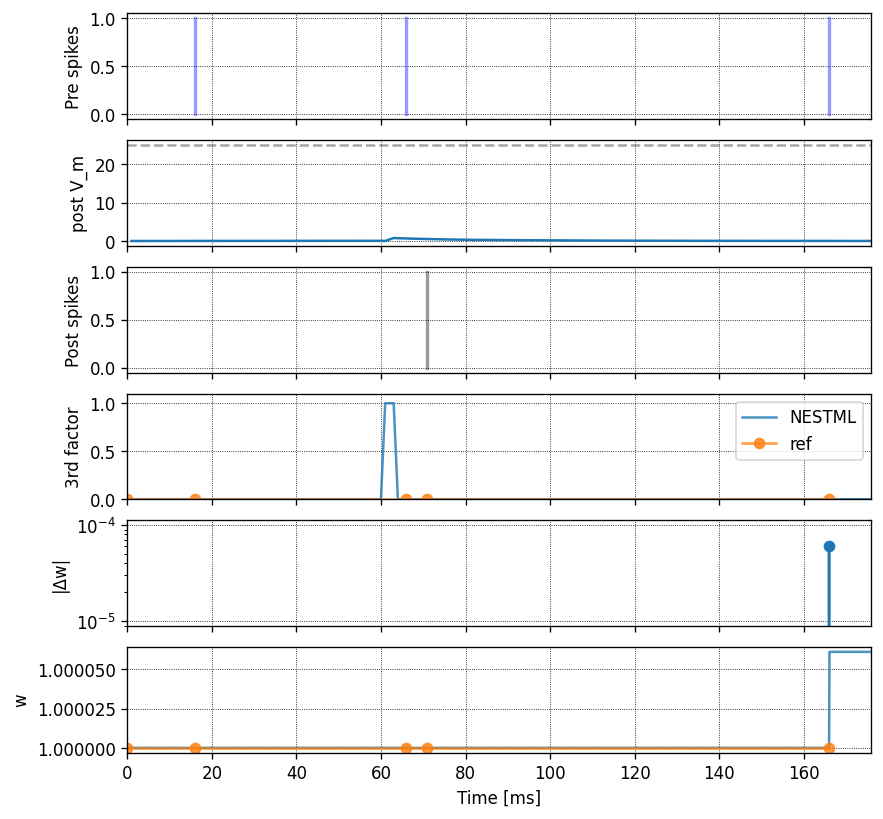

In [76]:
# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                                                               synapse_model_name=synapse_model_name,
                                                               resolution=.1,  # [ms]
                                                               delay=10.,  # [ms]
                                                               pre_spike_times=pre_spike_times,
                                                               post_spike_times=post_spike_times,
                                                               stepwise_times=stepwise_times,
                                                               stepwise_values=stepwise_values)

When the third factor timing is shifted to the time of the post spike, the gate is enabled at the time of the postsynaptic spike (from the timing perspective of the synapse, that is, at the time of the postsynaptic spike plus the dendritic propagation delay).

## Pre and post at the same time

## Check for different delays

### Case 4: Third factor active during both post- and pre-spike

If the dAP lasts longer, the presynaptic spike at t = 66 ms causes a depression of the synapse that is orders of magnitude larger than the small depression, so the net result is a depression at t = 66 ms.

In [ ]:
# run the simulation
sim_time = 101.
stepwise_times = [0.,
                  58.,
                  73.]  # try 66, 67 for edge case

stepwise_values = [0., 100., 0.]


timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                synapse_model_name=synapse_model_name,
                resolution=.1,  # [ms]
                delay=10.,  # [ms]
                pre_spike_times=pre_spike_times,
                post_spike_times=post_spike_times,
                stepwise_times=stepwise_times, stepwise_values=stepwise_values)


In [ ]:
assert len(np.unique(np.diff(w_hist))) == 2
np.testing.assert_allclose(np.amax(np.abs(np.diff(w_hist))), 6.647848e-05, rtol=1E-6)

### Case 5: Non-forced dynamics

Rather than forcing the value of I_dAP, we can also allow it to following the (ODE) dynamics defined in the model (by setting ``reset_I_dAP_after_AP`` to false), showing the gating for values between zero and the maximum value.

In [ ]:
fname_snip = ""

post_spike_times = np.concatenate(([10., 50.], 60. + np.sort(np.unique(1 + np.round(200 * np.sort(np.abs(np.random.rand(100)))))), [300., 350.]))      # [ms]
pre_spike_times = np.sort(np.unique(1 + np.round(400 * np.sort(np.abs(np.random.rand(100))))))      # [ms]

stepwise_times = [0.,
                  10.,
                  20.]
stepwise_values = [0., 1., None]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(neuron_model_name=neuron_model_name,
                        synapse_model_name=synapse_model_name,
                        resolution=.5,  # [ms]
                        delay=1.5,  # [ms]
                        pre_spike_times=pre_spike_times,
                        post_spike_times=post_spike_times,
                        sim_time=400.,
                        stepwise_times=stepwise_times, stepwise_values=stepwise_values, reset_I_dAP_after_AP=False)

References
----------

...







